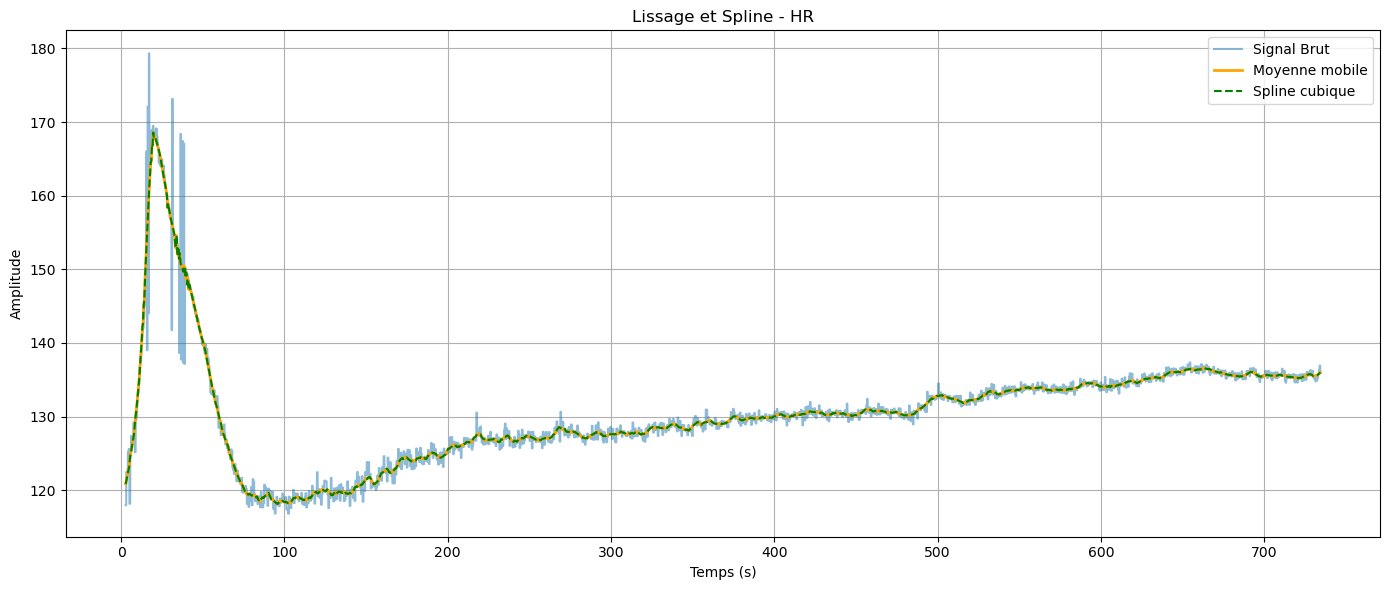

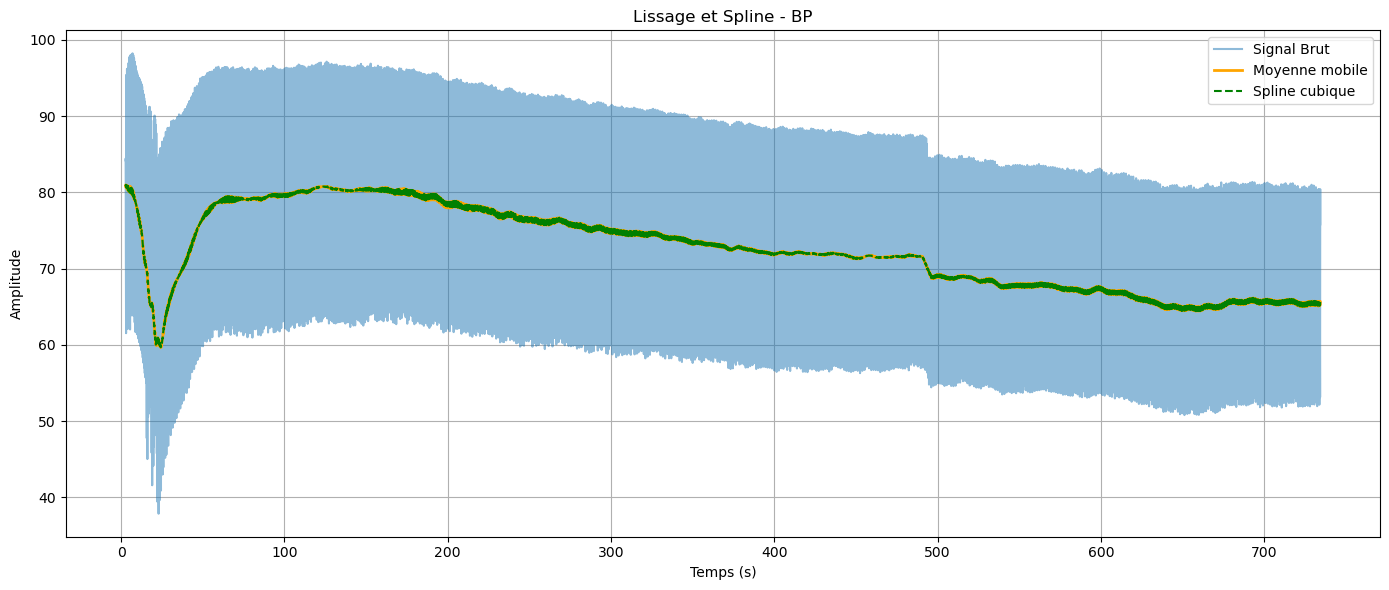

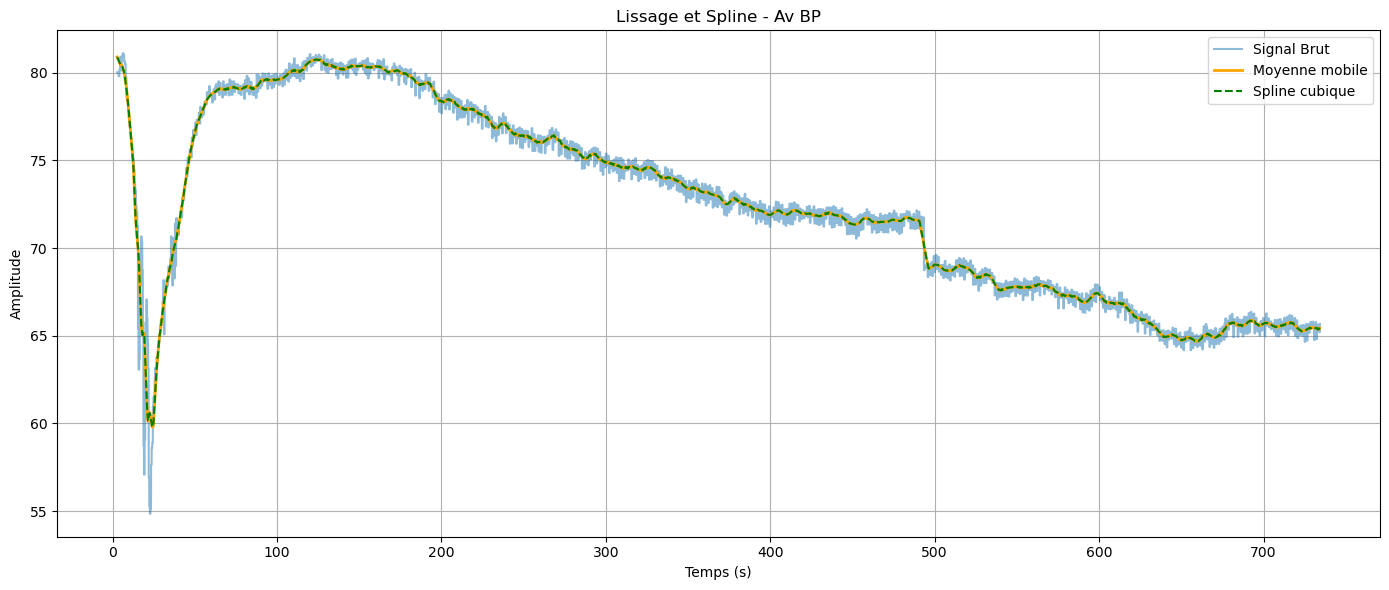

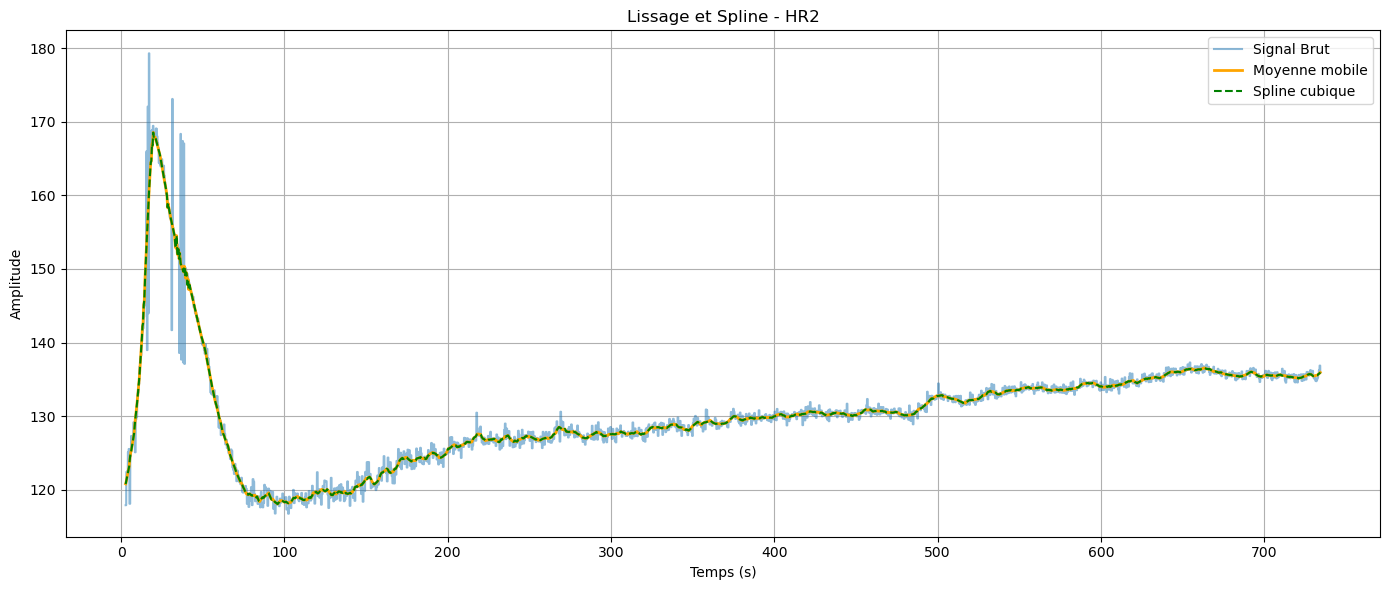

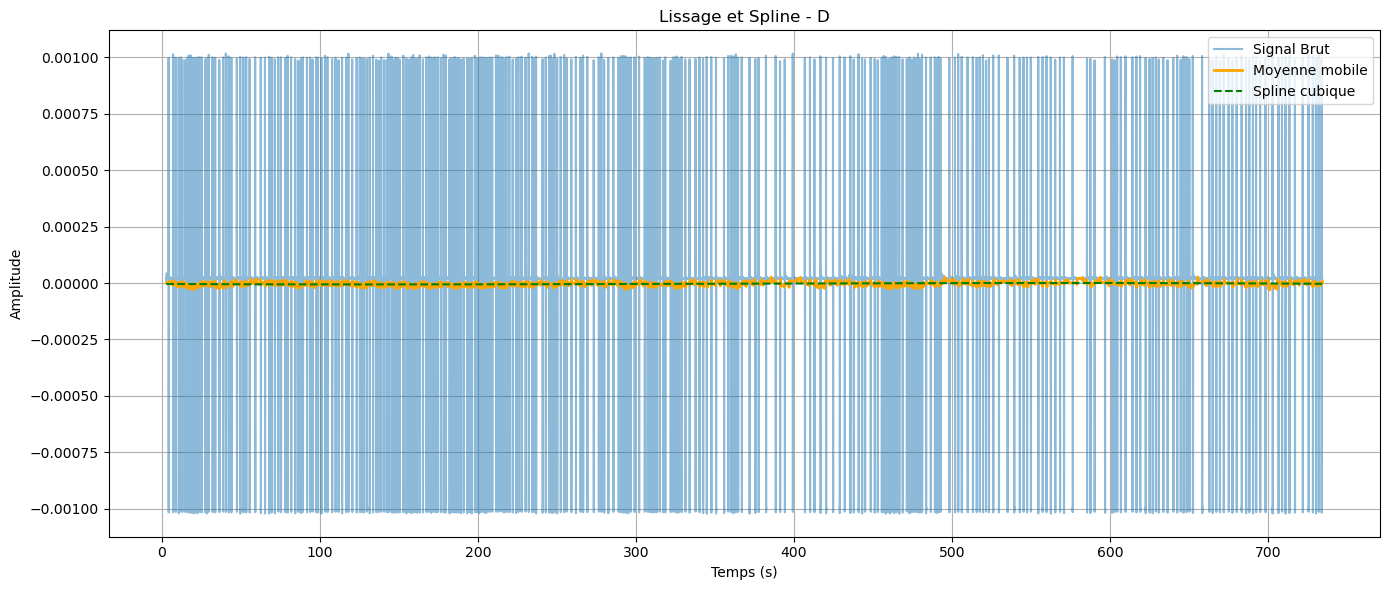

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def load_and_prepare_data(filepath, sampling_interval_ms=5, columns_to_use=None):
    df = pd.read_csv(filepath, sep="\t", header=None, encoding="ISO-8859-1", engine="python")
    all_columns = ["Time", "BP", "Av BP", "HR", "D", "HR2", "Comment", "Extra"]
    df.columns = all_columns[:df.shape[1]]

    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace(",", ".").str.strip()
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df.drop(columns=["Comment", "Extra"], errors="ignore", inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["Time"] = df.index * (sampling_interval_ms / 1000.0)

    if columns_to_use:
        df = df[["Time"] + columns_to_use]
    return df

def smooth_and_spline(df, column, rolling_window=1100, spline_s=1):
    df["rolling"] = df[column].rolling(window=rolling_window, center=True).mean()
    df_clean = df.dropna(subset=["rolling"]).copy()
    x = np.arange(len(df_clean))
    y = df_clean["rolling"].values
    spline = UnivariateSpline(x, y, s=spline_s)
    df_clean["spline"] = spline(x)
    return df_clean

def plot_smoothed_signals(df_clean, column):
    plt.figure(figsize=(14, 6))
    plt.plot(df_clean["Time"], df_clean[column], label="Signal Brut", alpha=0.5)
    plt.plot(df_clean["Time"], df_clean["rolling"], label="Moyenne mobile", linewidth=2, color='orange')
    plt.plot(df_clean["Time"], df_clean["spline"], label="Spline cubique", linestyle='--', color='green')
    plt.title(f"Lissage et Spline - {column}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Exemple d'utilisation ===
filepath = "../data/data1/Desmopressine.txt"  # ⚠️ adapte le chemin si besoin
columns_to_analyze = ["HR", "BP", "Av BP", "HR2", "D"]

df_raw = load_and_prepare_data(filepath, columns_to_use=columns_to_analyze)

for col in columns_to_analyze:
    df_clean = smooth_and_spline(df_raw[["Time", col]].copy(), column=col)
    plot_smoothed_signals(df_clean, column=col)
